# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Logistic Regression
- relatively fast

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from skopt import BayesSearchCV

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ChangedBehaviorWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning,
                                          ChangedBehaviorWarning,
                                          DeprecationWarning,
                                          RuntimeWarning))

/home/rei/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set up directories
SEED = 149028763
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y,
                                                    random_state=SEED)

Loaded 105822 samples with 4460 features


## Hyperparameter Tuning

Bayesian search on `LogisticRegression` with `BayesSearchCV`

In [5]:
# Set up classifier pipeline
estimator = LogisticRegression(solver='lbfgs', penalty='l2',
                               max_iter=3000, random_state=SEED)

pipe = Pipeline([('clf', estimator)])

In [6]:
# Callback function
def status_print(optim_result):
    """Status callback durring Bayesian hyperparameter search"""
    
    # Get current parameters and the best parameters 
    n = len(pd.DataFrame(opt.cv_results_))
    print('Iteration %i, best %s score: %.6f'\
          % (n, scoring, opt.best_score_))

In [7]:
# Perform hyperparameter optimization
param_space = {
    'clf__C': (0.125, 16, 'log-uniform')
    #'clf__l1_ratio': (0., 1., 'uniform')
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
scoring = 'neg_log_loss'

opt = BayesSearchCV(pipe, param_space,cv=cv, scoring=scoring, n_iter=50,
                    n_jobs=-1, verbose=0, random_state=SEED)

cv_results = opt.fit(X_train, y_train, callback=status_print)

Iteration 1, best neg_log_loss score: -0.146237
Iteration 2, best neg_log_loss score: -0.118020
Iteration 3, best neg_log_loss score: -0.117585
Iteration 4, best neg_log_loss score: -0.111987
Iteration 5, best neg_log_loss score: -0.111595
Iteration 6, best neg_log_loss score: -0.111595
Iteration 7, best neg_log_loss score: -0.111595
Iteration 8, best neg_log_loss score: -0.111595
Iteration 9, best neg_log_loss score: -0.111595
Iteration 10, best neg_log_loss score: -0.110187
Iteration 11, best neg_log_loss score: -0.110187
Iteration 12, best neg_log_loss score: -0.110186
Iteration 13, best neg_log_loss score: -0.110186
Iteration 14, best neg_log_loss score: -0.110186
Iteration 15, best neg_log_loss score: -0.110137
Iteration 16, best neg_log_loss score: -0.110137
Iteration 17, best neg_log_loss score: -0.110137
Iteration 18, best neg_log_loss score: -0.110137
Iteration 19, best neg_log_loss score: -0.110137
Iteration 20, best neg_log_loss score: -0.110137
Iteration 21, best neg_log_lo

In [8]:
# Set best estimator as classifier
opt.best_params_
print('Test %s score: %.4f' % (scoring, opt.score(X_test, y_test)))
clf = opt.best_estimator_

{'clf__C': 4.475505071347994}

Test neg_log_loss score: -0.1020


              precision    recall  f1-score   support

           0     0.9746    0.9985    0.9864     19657
           1     0.9708    0.6611    0.7866      1508

    accuracy                         0.9744     21165
   macro avg     0.9727    0.8298    0.8865     21165
weighted avg     0.9744    0.9744    0.9722     21165



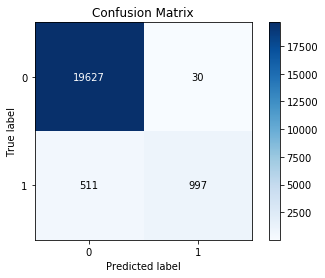

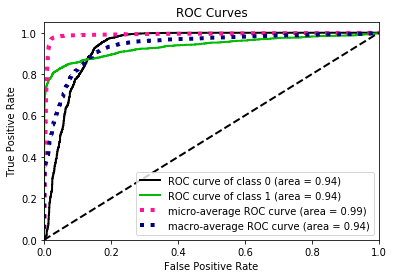

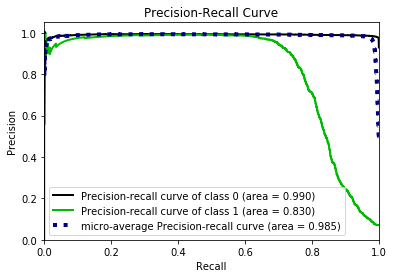

In [9]:
# Evaluate model
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print(classification_report(y_test, y_pred, digits=4))

# Plot metrics
_ = plot_confusion_matrix(y_test, y_pred)
_ = plot_roc(y_test, y_proba)
_ = plot_precision_recall(y_test, y_proba)
_ = plt.show()

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9704    0.9657    0.9681     36476
           1     0.5748    0.6118    0.5927      2764

    accuracy                         0.9408     39240
   macro avg     0.7726    0.7887    0.7804     39240
weighted avg     0.9426    0.9408    0.9416     39240



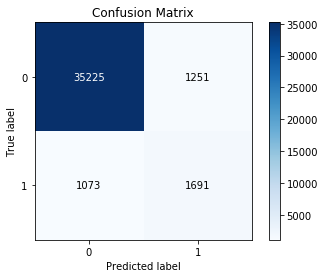

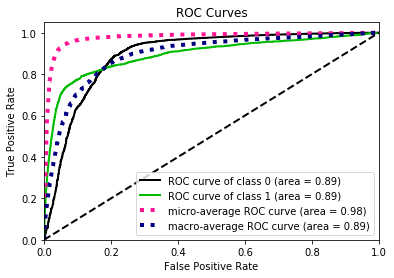

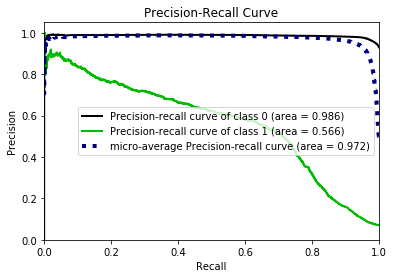

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9687    0.9777    0.9732     49151
           1     0.6502    0.5674    0.6060      3590

    accuracy                         0.9498     52741
   macro avg     0.8094    0.7726    0.7896     52741
weighted avg     0.9470    0.9498    0.9482     52741



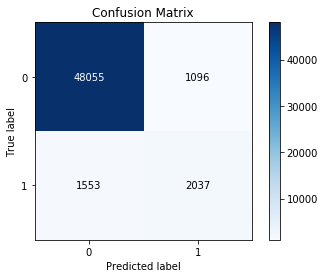

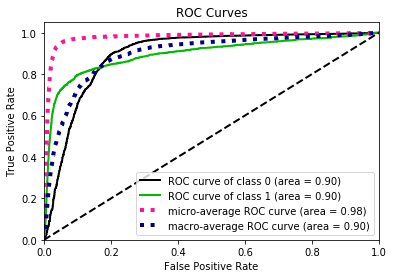

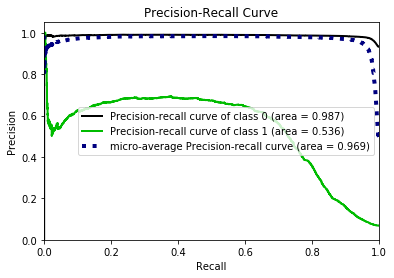

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9727    0.9815    0.9771     12654
           1     0.7819    0.7068    0.7425      1187

    accuracy                         0.9580     13841
   macro avg     0.8773    0.8442    0.8598     13841
weighted avg     0.9564    0.9580    0.9570     13841



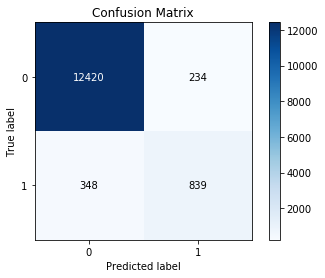

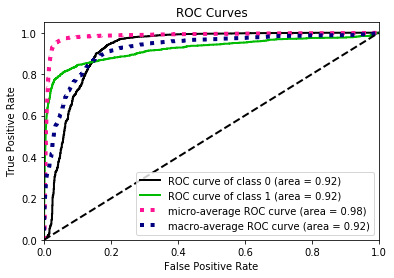

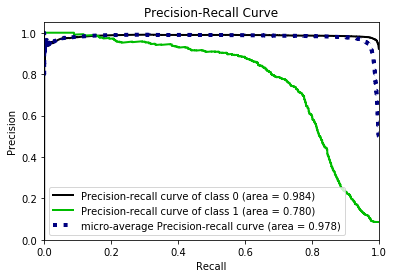

<hr></hr>

In [10]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier with validation set
    _ = clf.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plot_precision_recall(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))

In [11]:
# Refit model with the whole dataset
_ = pipe.fit(X, y)

# Dump model as pickle
_ = joblib.dump(clf, 'best_model.pkl')